# 03 - Clustering Analysis

## Overview
This notebook performs comprehensive clustering analysis using multiple algorithms to identify distinct company profiles based on ESG and financial performance.

**Prerequisites:**
- Complete `01_Data_Exploration_EDA.ipynb`
- Complete `02_Data_Preprocessing.ipynb`
- Datasets: `../Data/scaled_features.csv`, `../Data/pca_features.csv`

**Objectives:**
- Determine optimal number of clusters
- Apply multiple clustering algorithms
- Validate and compare clustering results
- Analyze cluster characteristics

**Outputs:**
- Optimal cluster assignments
- Clustering performance metrics
- Cluster analysis and profiling
- Visualizations and insights

## 1. Library Imports and Setup

In [1]:
# Standard libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Clustering algorithms
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture

# Clustering validation metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform

# Optimal cluster number detection
from kneed import KneeLocator
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Utilities
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Clustering libraries imported successfully!")

Clustering libraries imported successfully!


## 2. Load Preprocessed Data

In [2]:
# Load preprocessed datasets
try:
    X_scaled = pd.read_csv('../Data/scaled_features.csv')
    X_pca = pd.read_csv('../Data/pca_features.csv')
    data_complete = pd.read_csv('../Data/preprocessed_complete_dataset.csv')
    
    print(f"Scaled features loaded: {X_scaled.shape}")
    print(f"PCA features loaded: {X_pca.shape}")
    print(f"Complete dataset loaded: {data_complete.shape}")
    
except FileNotFoundError as e:
    print(f"Preprocessed data not found: {e}")
    print("Please run 02_Data_Preprocessing.ipynb first.")
    raise

print(f"\nScaled features columns: {list(X_scaled.columns)}")
print(f"PCA features columns: {list(X_pca.columns)}")

Scaled features loaded: (11000, 11)
PCA features loaded: (11000, 7)
Complete dataset loaded: (11000, 36)

Scaled features columns: ['Revenue', 'ProfitMargin', 'MarketCap', 'GrowthRate', 'ESG_Overall', 'ESG_Environmental', 'ESG_Social', 'ESG_Governance', 'CarbonEmissions', 'WaterUsage', 'EnergyConsumption']
PCA features columns: ['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5', 'PCA_6', 'PCA_7']


## 3. Optimal Number of Clusters

### 3.1 Elbow Method

Optimal number of clusters (Elbow method): 4


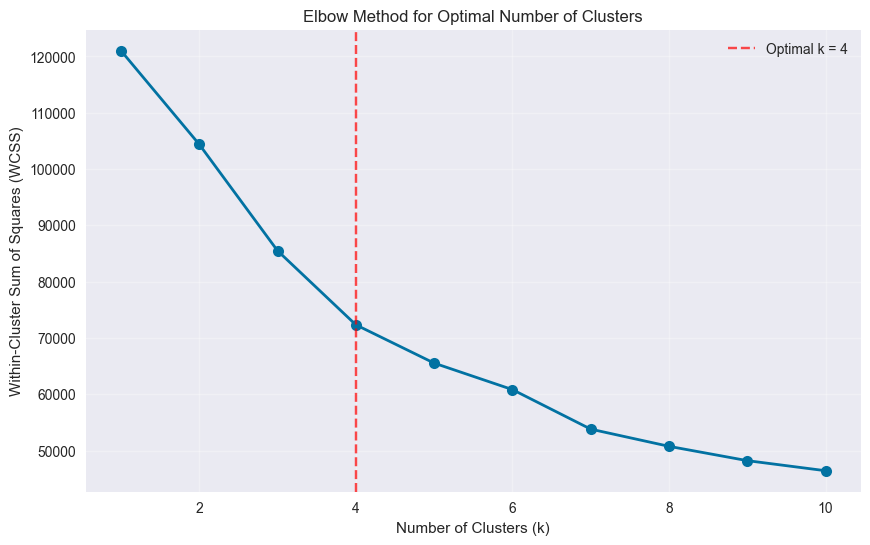

In [3]:
# Elbow method for K-Means
def calculate_wcss(X, max_k=10):
    wcss = []
    k_range = range(1, max_k + 1)
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
    
    return k_range, wcss

# Calculate WCSS for scaled features
k_range, wcss = calculate_wcss(X_scaled, max_k=10)

# Find optimal k using KneeLocator
knee_locator = KneeLocator(k_range, wcss, curve='convex', direction='decreasing')
optimal_k_elbow = knee_locator.elbow

print(f"Optimal number of clusters (Elbow method): {optimal_k_elbow}")

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, 'bo-', linewidth=2, markersize=8)
plt.axvline(x=optimal_k_elbow, color='red', linestyle='--', alpha=0.7, label=f'Optimal k = {optimal_k_elbow}')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 3.2 Silhouette Analysis

Optimal number of clusters (Silhouette method): 4
Maximum silhouette score: 0.195


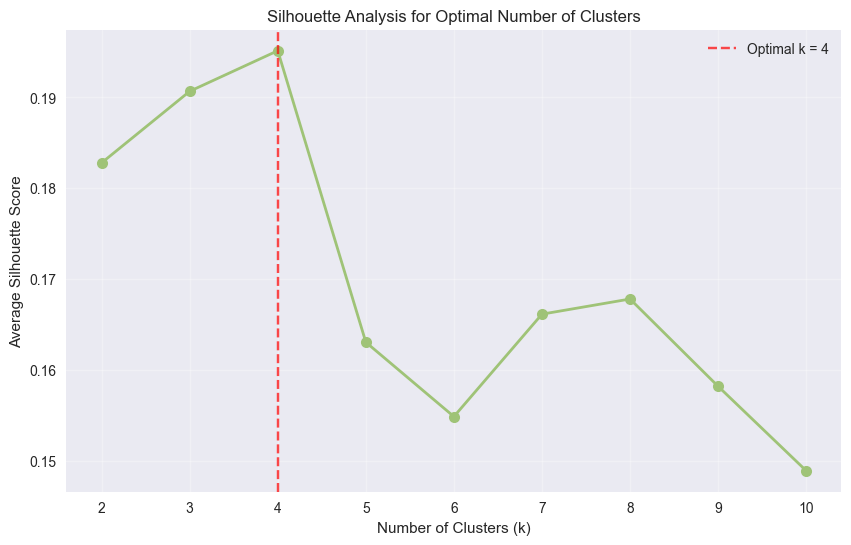

In [4]:
# Silhouette analysis
def calculate_silhouette_scores(X, max_k=10):
    silhouette_scores = []
    k_range = range(2, max_k + 1)  # Silhouette score requires at least 2 clusters
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    
    return k_range, silhouette_scores

# Calculate silhouette scores
k_range_sil, silhouette_scores = calculate_silhouette_scores(X_scaled, max_k=10)

# Find optimal k
optimal_k_silhouette = k_range_sil[np.argmax(silhouette_scores)]
max_silhouette_score = max(silhouette_scores)

print(f"Optimal number of clusters (Silhouette method): {optimal_k_silhouette}")
print(f"Maximum silhouette score: {max_silhouette_score:.3f}")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_range_sil, silhouette_scores, 'go-', linewidth=2, markersize=8)
plt.axvline(x=optimal_k_silhouette, color='red', linestyle='--', alpha=0.7, 
           label=f'Optimal k = {optimal_k_silhouette}')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Analysis for Optimal Number of Clusters')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 4. Clustering Algorithm Implementation

### 4.1 K-Means Clustering

In [5]:
# Use the better of the two optimal k values
optimal_k = optimal_k_silhouette if max_silhouette_score > 0.5 else optimal_k_elbow
print(f"Using optimal k = {optimal_k} for clustering analysis")

# Apply K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Calculate clustering metrics
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
kmeans_calinski = calinski_harabasz_score(X_scaled, kmeans_labels)
kmeans_davies = davies_bouldin_score(X_scaled, kmeans_labels)

print(f"\nK-Means Clustering Results (k={optimal_k}):")
print(f"Silhouette Score: {kmeans_silhouette:.3f}")
print(f"Calinski-Harabasz Score: {kmeans_calinski:.3f}")
print(f"Davies-Bouldin Score: {kmeans_davies:.3f}")

# Add cluster labels to data
data_complete['KMeans_Cluster'] = kmeans_labels

# Show cluster distribution
cluster_counts = pd.Series(kmeans_labels).value_counts().sort_index()
print(f"\nCluster distribution:")
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} companies ({count/len(kmeans_labels)*100:.1f}%)")

Using optimal k = 4 for clustering analysis

K-Means Clustering Results (k=4):
Silhouette Score: 0.195
Calinski-Harabasz Score: 2475.498
Davies-Bouldin Score: 1.361

Cluster distribution:
Cluster 0: 293 companies (2.7%)
Cluster 1: 26 companies (0.2%)
Cluster 2: 5256 companies (47.8%)
Cluster 3: 5425 companies (49.3%)

K-Means Clustering Results (k=4):
Silhouette Score: 0.195
Calinski-Harabasz Score: 2475.498
Davies-Bouldin Score: 1.361

Cluster distribution:
Cluster 0: 293 companies (2.7%)
Cluster 1: 26 companies (0.2%)
Cluster 2: 5256 companies (47.8%)
Cluster 3: 5425 companies (49.3%)


### 4.2 Hierarchical Clustering

In [6]:
# Apply Agglomerative Clustering
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_scaled)

# Calculate metrics
hierarchical_silhouette = silhouette_score(X_scaled, hierarchical_labels)
hierarchical_calinski = calinski_harabasz_score(X_scaled, hierarchical_labels)
hierarchical_davies = davies_bouldin_score(X_scaled, hierarchical_labels)

print(f"Hierarchical Clustering Results (k={optimal_k}):")
print(f"Silhouette Score: {hierarchical_silhouette:.3f}")
print(f"Calinski-Harabasz Score: {hierarchical_calinski:.3f}")
print(f"Davies-Bouldin Score: {hierarchical_davies:.3f}")

data_complete['Hierarchical_Cluster'] = hierarchical_labels

Hierarchical Clustering Results (k=4):
Silhouette Score: 0.153
Calinski-Harabasz Score: 2058.330
Davies-Bouldin Score: 1.511


### 4.3 DBSCAN Clustering

In [7]:
# Apply DBSCAN with automatic parameter selection
from sklearn.neighbors import NearestNeighbors

# Find optimal eps using k-distance graph
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:, 4], axis=0)

# Use knee point as eps
knee = KneeLocator(range(len(distances)), distances, curve='convex', direction='increasing')
optimal_eps = distances[knee.knee] if knee.knee else 0.5

print(f"Optimal eps for DBSCAN: {optimal_eps:.3f}")

# Apply DBSCAN
dbscan = DBSCAN(eps=optimal_eps, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Check if clustering is meaningful
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"\nDBSCAN Results:")
print(f"Number of clusters: {n_clusters_dbscan}")
print(f"Number of noise points: {n_noise}")

if n_clusters_dbscan > 1:
    # Calculate metrics (excluding noise points)
    mask = dbscan_labels != -1
    if mask.sum() > 1:
        dbscan_silhouette = silhouette_score(X_scaled[mask], dbscan_labels[mask])
        print(f"Silhouette Score (excluding noise): {dbscan_silhouette:.3f}")
    
    data_complete['DBSCAN_Cluster'] = dbscan_labels
else:
    print("DBSCAN did not find meaningful clusters with current parameters.")
    data_complete['DBSCAN_Cluster'] = -1

Optimal eps for DBSCAN: 2.912

DBSCAN Results:
Number of clusters: 3
Number of noise points: 40

DBSCAN Results:
Number of clusters: 3
Number of noise points: 40
Silhouette Score (excluding noise): 0.786
Silhouette Score (excluding noise): 0.786


## 5. Save Clustering Results

In [8]:
# Save the complete dataset with cluster assignments
data_complete.to_csv('../Data/clustered_dataset.csv', index=False)

# Create a summary of clustering results
clustering_summary = {
    'Algorithm': ['K-Means', 'Hierarchical', 'DBSCAN'],
    'Number_of_Clusters': [optimal_k, optimal_k, n_clusters_dbscan],
    'Silhouette_Score': [kmeans_silhouette, hierarchical_silhouette, 
                        dbscan_silhouette if 'dbscan_silhouette' in locals() else 'N/A'],
    'Calinski_Harabasz_Score': [kmeans_calinski, hierarchical_calinski, 'N/A'],
    'Davies_Bouldin_Score': [kmeans_davies, hierarchical_davies, 'N/A']
}

clustering_results_df = pd.DataFrame(clustering_summary)
clustering_results_df.to_csv('../Data/clustering_comparison.csv', index=False)

print("Clustering results saved:")
print("- ../Data/clustered_dataset.csv")
print("- ../Data/clustering_comparison.csv")

print(f"\nBest performing algorithm based on silhouette score:")
print(clustering_results_df.sort_values('Silhouette_Score', ascending=False).head(1))

print(f"\nReady for cluster analysis and visualization!")
print(f"Dataset with clusters shape: {data_complete.shape}")

Clustering results saved:
- ../Data/clustered_dataset.csv
- ../Data/clustering_comparison.csv

Best performing algorithm based on silhouette score:
  Algorithm  Number_of_Clusters  Silhouette_Score Calinski_Harabasz_Score  \
2    DBSCAN                   3          0.786112                     N/A   

  Davies_Bouldin_Score  
2                  N/A  

Ready for cluster analysis and visualization!
Dataset with clusters shape: (11000, 39)
